Кейс №1 - Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
import math
import pingouin as pg
from scipy.stats import chi2_contingency, chi2
from statistics import variance, pvariance
# Font size will be increased, background of figures will be white, grid will be present and size of plots will be increased

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [2]:
# Загрузим данные
badu = pd.read_csv('dating_data.csv')

In [3]:
# Посмотрим на них
badu.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
# На кол-во строк и пропусков + тип данных
badu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [5]:
# Посмотрев на жисперсию, видим что она у нас разная. ПОэтому применим Welch’s t-test.
variance(badu[badu.group == 1].is_match), variance(badu[badu.group == 0].is_match)

(0.2404359663833038, 0.15695173441856236)

In [6]:
# Посмотрим на кол-во лакнувших друг друга пользователей по группам, можно уже заметить, что кол-во взаимных лайков возросло в 1 группе.
badu.groupby(['group', 'is_match']) \
    .agg({'user_id_1': 'count'})

user_id_1
group is_match           
0     0              3858
      1               934
1     0              5813
      1              3909

In [7]:
# Проведем разведывательный анализ конверсии 
badu.groupby(['group']) \
    .agg({'is_match': 'mean'})

,is_match
group,
0,0.194908
1,0.402078


In [8]:
# кол-во оценок
badu.groupby(['group']) \
    .agg({'is_match': 'count'})

,is_match
group,
0,4792
1,9722


In [9]:
# Кол-во уникальных пользователей на группу
pd.concat((badu[['user_id_1', 'group', 'is_match']].rename(columns={'user_id_1': 'user_id'}), 
           badu[['user_id_2', 'group', 'is_match']].rename(columns={'user_id_2': 'user_id'}))) \
           .groupby(['group'], as_index=False) \
           .agg({'user_id': pd.Series.nunique})

,group,user_id
0,0,501
1,1,499


In [10]:
# Используем Welch’s t-test. H0 - средние значения мэтчей групп 0 и 1 равны. H1 средние значения мэтчей групп 0 и 1 не равны.\
# Т.к. pvalue=2.4382628013660826e-159 < 0.05 отвергаем H0. 
# У нас есть достаточно доказательств, чтобы сказать, что среднее кол-во мэтчей теста отличается для групп 0 и 1 .
stats.ttest_ind(badu.loc[badu.group == 0, 'is_match'], badu.loc[badu.group == 1, 'is_match'], equal_var=False)

TtestResult(statistic=-27.324520144476963, pvalue=2.4382628013660826e-159, df=11520.535231159185)

In [11]:
#  Создадим таблицу со всеми событиями
events = pd.concat((badu[['user_id_1', 'group', 'is_match']].rename(columns={'user_id_1': 'user_id'}), 
                          badu[['user_id_2', 'group', 'is_match']].rename(columns={'user_id_2': 'user_id'})))

In [12]:
# Посчитаем кол-во событий на уникального пользователя
events_count = events.groupby(['user_id', 'group'], as_index=False).count()

In [13]:
# Используем Welch’s t-test. H0 - пользователи из групп 0 и 1 в среднем совершали одинаковые кол-ва действий. H1 пользователи из групп 0 и 1 в среднем совершали разное кол-во действий.\
# Т.к. pvalue=0 < 0.05 отвергаем H0. 
# У нас есть достаточно доказательств, чтобы сказать, пользователи из групп 0 и 1 в среднем совершали разное кол-во действий.
stats.ttest_ind(events_count.loc[events_count.group == 0, 'is_match'], events_count.loc[events_count.group == 1, 'is_match'], equal_var=False)

TtestResult(statistic=-62.81020734004636, pvalue=0.0, df=952.8731865785683)

<Axes: xlabel='is_match', ylabel='Count'>

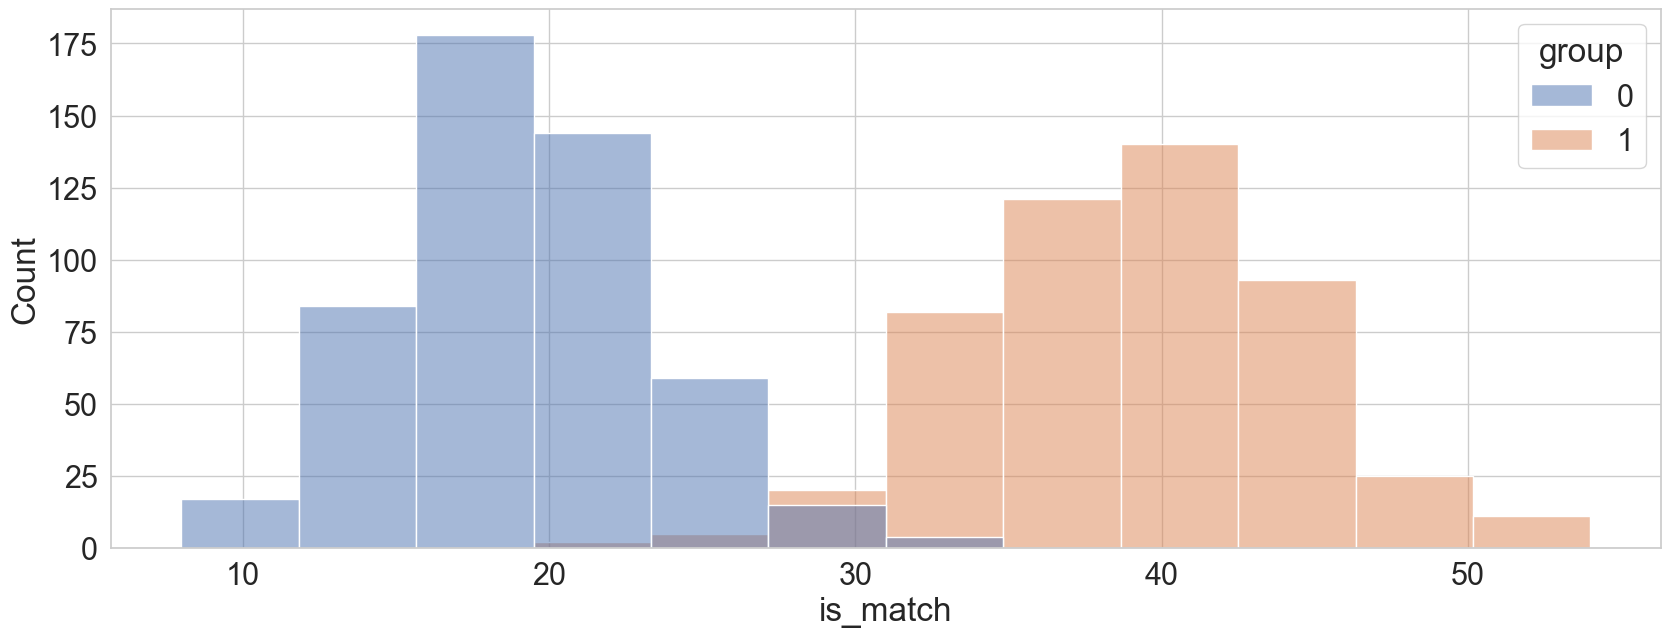

In [14]:
# Отобразим на графике кол-во действий пользователей по группам. По которому заметим что пользователи из 1 группы совершали больше действий
sns.histplot(events_count[['group', 'is_match']], x="is_match", hue="group")

In [15]:
# Посчитаем кол-во мэтчей на уникального пользователя
matches_counts = events.groupby(['user_id', 'group'], as_index=False).sum()

In [16]:
# Используем Welch’s t-test. H0 - пользователи из групп 0 и 1 в среднем совершали одинаковые кол-ва мэтчей. H1 пользователи из групп 0 и 1 в среднем совершали разное кол-во мэтчей.\
# Т.к. pvalue=7.010294561635124e-295 < 0.05 отвергаем H0. 
# У нас не достаточно доказательств сказать, что пользователи из групп 0 и 1 в среднем совершали разное кол-во мэтчей.
stats.ttest_ind(matches_counts.loc[matches_counts.group == 0, 'is_match'], matches_counts.loc[matches_counts.group == 1, 'is_match'], equal_var=False)

TtestResult(statistic=-61.60792790329727, pvalue=7.010294561635124e-295, df=746.2534212202238)

<Axes: xlabel='is_match', ylabel='Count'>

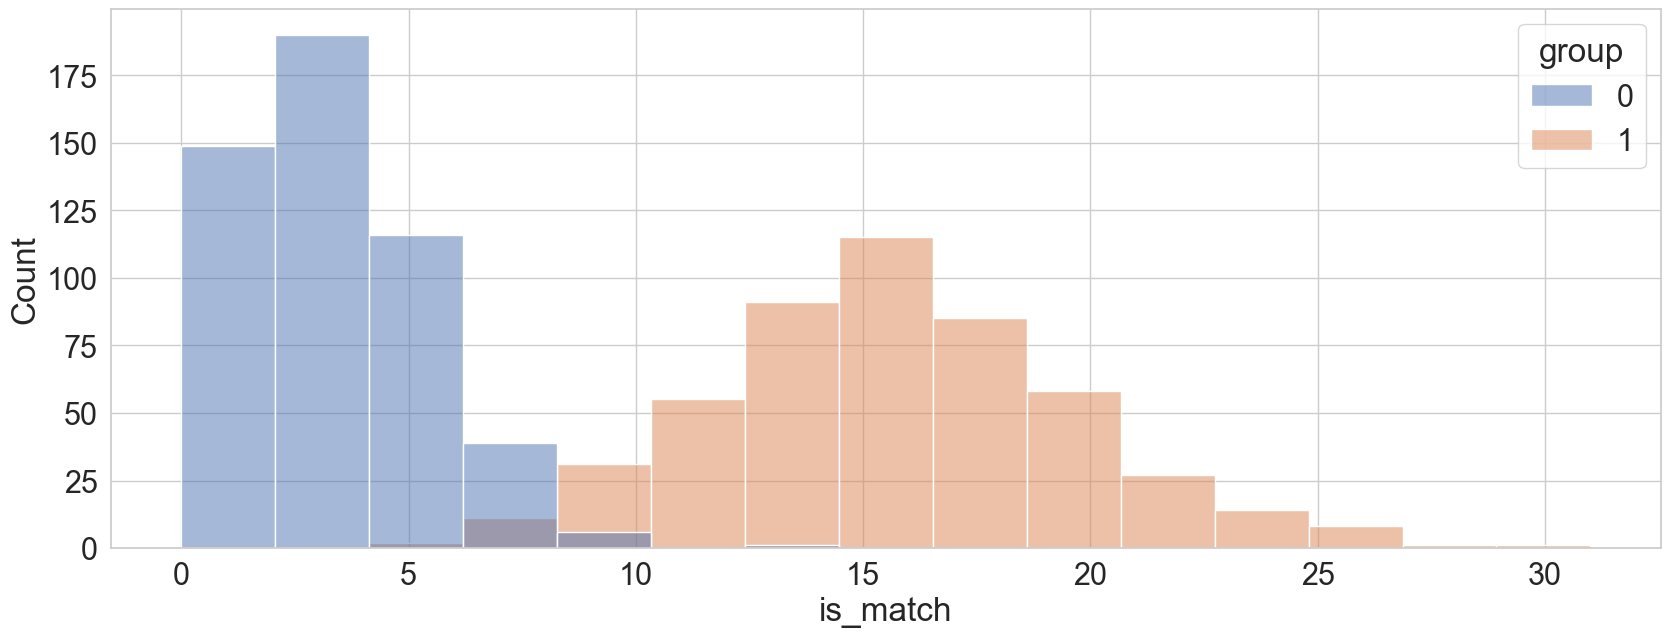

In [17]:
# Отобразим на графике кол-во мэтчей пользователей по группам. По которому заметим что пользователи из 1 группы совершали больше мэтчей
sns.histplot(matches_counts[['group', 'is_match']], x="is_match", hue="group")

## Вывод
Пользователи из 1 группы, которые пользовались приложением с новым алгоритмом для поиска анкет, совершали в среднем большей действий и мэтчей. Поэтому можно утверждать, что новый алгоритм улучшил качество сервиса. Люди стали больше проводить времени в сервисе и чаще ставить взаимные лайки. Эти изменения статзначимы.